In [157]:
import pandas as pd
import numpy as np
import requests
import re
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import time

## Get Board game IDs from csv file provided by boardgamegeek.com

In [135]:
ids = pd.read_csv("boardgames_ranks.csv")

In [136]:
#Select top 1000
ids = ids["id"]
ids = ids[0:1000]

## Set up portions of url

In [85]:
baseurl = "https://boardgamegeek.com/xmlapi2"
endpoint = "/thing?id="
parameter1 = str(ids[0])
parameter2 = "&stats=1&marketplace=1"

## Initialize data fields

In [163]:
name = []
yearpublished = []
minplayers = []
maxplayers = []
playingtime = []
minage = []
accessory_num = []
users_rated = []
averagescore = []
bayesaveragescore = []
stddev = []
avg_USD_price = []

## Create for loop that pulls data for each board game in ID list

In [ ]:
for x in range(0,len(ids)):
    parameter1 = str(ids[x])
    time.sleep(5) #so that requests don't get throttled
    if x % 10 == 0:
        print(x)
    url = baseurl + endpoint + parameter1 + parameter2
    r = requests.get(url)
    if r.status_code == 429: #to prevent going on with the code when request is denied for too much traffic
        time.sleep(10)
        r = requests.get(url)
    if r.status_code == 429:
        time.sleep(10)
        r = requests.get(url)
    soup = BeautifulSoup(r.content, "xml")
    name.append(soup.find("name")["value"])
    yearpublished.append(soup.find("yearpublished")["value"])
    minplayers.append(soup.find("minplayers")["value"])
    maxplayers.append(soup.find("maxplayers")["value"])
    playingtime.append(soup.find("playingtime")["value"])
    minage.append(soup.find("minage")["value"])
    accessory_num.append(len(soup.find_all("link", type="boardgameaccessory")))
    users_rated.append(soup.find("usersrated")["value"])
    averagescore.append(soup.find("average")["value"])
    stddev.append(soup.find("stddev")["value"])
    bayesaveragescore.append(soup.find("bayesaverage")["value"])
    usd_prices = [float(item["value"]) for item in soup.find_all("price", currency = "USD")]
    if len(usd_prices) == 0:
        avg_USD_price.append(None)
    else:
        avg_USD_price.append(sum(usd_prices)/len(usd_prices))

## Create data frame from lists

In [189]:
boardGames = pd.DataFrame({"Title": name, "Year Published": yearpublished, "Min Players": minplayers, "Max Players": maxplayers, "Playing Time": playingtime, "Age Minimum": minage, "Number of Accessories": accessory_num, "Number of Ratings": users_rated, "Average Rating": averagescore, "Bayes Rating": bayesaveragescore, "Standard Deviation": stddev, "Average USD Price": avg_USD_price})


In [190]:
boardGames.to_csv("boardgamesdata.csv")

## Feature Engineer Extra Variables and create numeric columns

In [191]:
boardGames["Age (Years)"] = 2023 - boardGames["Year Published"].astype(int)

In [195]:
boardGames["Playing Time"] = boardGames["Playing Time"].astype(int)

### Check distribution for playing times to create best categories

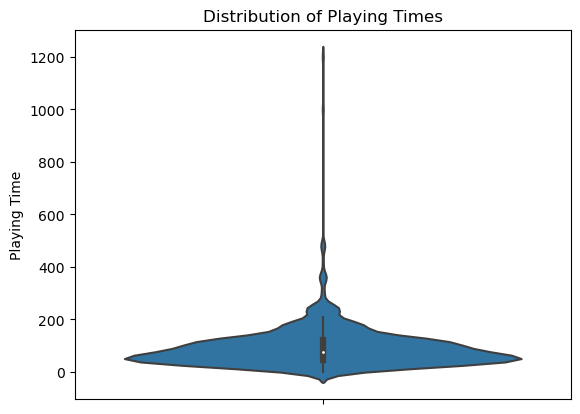

In [201]:
sns.violinplot(data = boardGames, y = "Playing Time")
plt.title("Distribution of Playing Times")
plt.savefig("PlayingTimeDistribution.png")

In [197]:
boardGames["Time Category"] = pd.cut(boardGames["Playing Time"], bins=[0,31,61,91,181,301,1501], labels = ["Quick", "Short", "Moderate", "Long", "Very Long", "Marathon"])

In [ ]:
num_cols = ["Year Published", "Min Players", "Max Players", "Age Minimum", "Number of Accessories", "Number of Ratings", "Average Rating", "Bayes Rating", "Standard Deviation", "Average USD Price"]
boardGames[num_cols] = boardGames[num_cols].apply(pd.to_numeric)


### Check distribution of min ages to create best categories

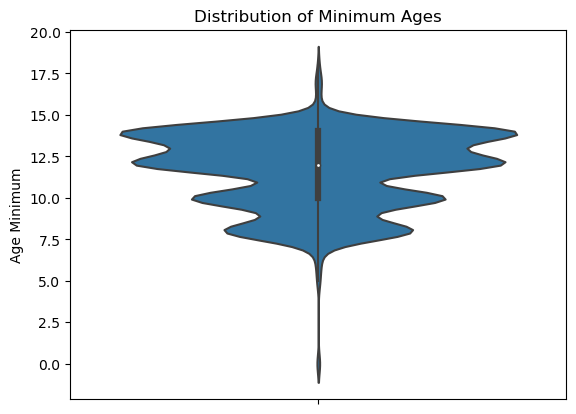

In [208]:
sns.violinplot(data=boardGames, y = "Age Minimum")
plt.title("Distribution of Minimum Ages")
plt.savefig("MinAgeDistribution.png")


In [209]:
boardGames["AgeRating"] = pd.cut(boardGames["Age Minimum"], bins=[0,5,8,12,16,24], labels = ["Any", "Young", "PreTeen", "Teen", "Adult"])

Text(0.5, 1.0, 'Distribution of Max Players')

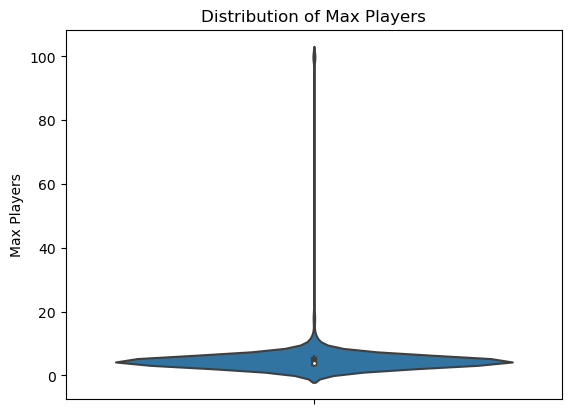

In [213]:
sns.violinplot(data=boardGames, y = "Max Players")
plt.title("Distribution of Max Players")

In [217]:
boardGames["Max Players"].median()

4.0

In [218]:
boardGames["GroupSize"] = pd.cut(boardGames["Max Players"], bins=[0, 1, 4, 8, 101], labels = ["Individual", "Small", "Large", "Massive"])

In [220]:
boardGames.to_csv("boardgamesdata.csv", index = False)